# iBeacon Understanding and Feature Engineering

The aim of this notebook is to get a better understanding of the iBeacon technology. According to [Wikipedia](https://en.wikipedia.org/wiki/IBeacon) "iBeacon is a protocol developed by Apple [...] in 2013. Various vendors have since made iBeacon-compatible hardware transmitters – typically called beacons – a class of **Bluetooth Low Energy (BLE) devices** that broadcast their identifier to nearby portable electronic devices."

In regards to using the iBeacon technology for precise indoor localization, the [Apple developers' guide ](https://developer.apple.com/ibeacon/Getting-Started-with-iBeacon.pdf) states: "Due to the issues around signal strength and the variabilities in deployment environments, **iBeacon technology is not intended to be used for specific location identification. It should be capable of providing room-level accuracy**, but there are many factors that need to be considered to build a successful deployment."

The fact that iBeacon technology is not precise at meter-level is also reflected in this [discussion topic "How much value is TYPE_BEACON adding?"](https://www.kaggle.com/c/indoor-location-navigation/discussion/222488). Nonetheless, let's explore this topic a little bit.

In [ ]:
import numpy as np
import pandas as pd
pd.set_option("display.max_colwidth", 50)
    
import matplotlib.pyplot as plt
import seaborn as sns

import glob
import os
import sys
import math
import gc
import json 
import re
from tqdm import tqdm

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

PATH = '../input/indoor-location-navigation/'

submission = pd.read_csv(f'{PATH}sample_submission.csv')

# iBeacon Features 
As described on the [competitions GitHub page](https://github.com/location-competition/indoor-location-competition-20), the provided iBeacon data contains following features:
* UUID: Identifier specific to the app and deployment use case [2]
* MajorID: Further specification for iBeacon and use case [2]
* MinorID: Further specification of region or use case [2]
* TxPower
* RSSI
* Distance: The distance is calculated from TxPower and RSSI
* MAC Address

"The UUID, major and minor values provide the identifying information for the iBeacon" [2]

The following function is edited from [the repository's](https://github.com/location-competition/indoor-location-competition-20/blob/master/io_f.py) original function ` read_data_file(data_filename)` with a focus on iBeacon data. While the original function only exracted timestamp, identifier (joined from UUID, MajorID and MinorID) and RSSI, we will be **also extracting the distance**.

In [ ]:
#  The following code is copied and edited https://github.com/location-competition/indoor-location-competition-20
from dataclasses import dataclass

@dataclass
class ReadData:
    # Removed other signal info acquisition for simplicity reasons ...
    ibeacon: np.ndarray
    waypoint: np.ndarray


def read_data_file(data_filename):
    # Removed other signal info acquisition for simplicity reasons ...
    ibeacon = []
    waypoint = []

    with open(data_filename, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    for line_data in lines:
        line_data = line_data.strip()
        if not line_data or line_data[0] == '#':
            continue

        line_data = line_data.split('\t')

        # Removed other signal info acquisition for simplicity reasons ...

        if line_data[1] == 'TYPE_BEACON':
            ts = line_data[0]
            uuid = line_data[2]
            major = line_data[3]
            minor = line_data[4]
            rssi = line_data[6]
            distance = line_data[7] # Newly added
            
            ibeacon_data = [ts, '_'.join([uuid, major, minor]), rssi, distance]
            
            ibeacon.append(ibeacon_data)
            continue

        if line_data[1] == 'TYPE_WAYPOINT':
            waypoint.append([int(line_data[0]), float(line_data[2]), float(line_data[3])])

    # Removed other signal info acquisition for simplicity reasons ...

    ibeacon = np.array(ibeacon)
    waypoint = np.array(waypoint)

    return ReadData(ibeacon, waypoint)

In [ ]:
"""
### Help Functions ###

Here we are setting up help functions that will be used in the following.

## Git Repository ##
https://github.com/location-competition/indoor-location-competition-20

The `read_data_file` function from the repository returns a class `ReadData` with the following attributes: `acce`, `acce_uncali`, `gyro`, `gyro_uncali`, `magn`, `magn_uncali`, `ahrs`, `wifi`, `ibeacon`, `waypoint`.

## Further Utility Functions ##
from https://www.kaggle.com/jiweiliu/wifi-label-encode
"""

def encode_floor(floor):
    """
    Encodes floor string to integer
    """
    # Get floor number
    encoded_floor = int(re.findall('[0-9]+', floor)[0])
    
    if floor.find('B') == 0:
        # Multiply with -1 incase of B floor
        encoded_floor = (-1)*encoded_floor
    else: 
        # Subtract one floor to start at 0 for F1
        encoded_floor = encoded_floor -1
        
    return encoded_floor

# The following code is copied and edited from https://www.kaggle.com/jiweiliu/wifi-label-encode
ACOLS = ['timestamp','x','y','z']
        
FIELDS = {
    'acce': ACOLS,
    'acce_uncali': ACOLS,
    'gyro': ACOLS,
    'gyro_uncali': ACOLS,
    'magn': ACOLS,
    'magn_uncali': ACOLS,
    'ahrs': ACOLS,
    'wifi': ['timestamp','ssid','bssid','rssi','last_timestamp'],
    'ibeacon': ['timestamp','id','rssi', 'distance'],
    'waypoint': ['timestamp','x','y']
}

def create_dummy_df(cols):
    """
    Edited from https://www.kaggle.com/jiweiliu/wifi-label-encode
    """
    df = pd.DataFrame()
    for col in cols:
        df[col] = [0]
        if col in ['ssid','bssid']:
            df[col] = df[col].map(str)
    return df

def to_frame(data, col):    
    """
    Edited from https://www.kaggle.com/jiweiliu/wifi-label-encode
    """
    cols = FIELDS[col]
    if data.shape[0]>0:
        df = pd.DataFrame(data, columns=cols)
    else:
        df = create_dummy_df(cols)
    for col in df.columns:
        if 'timestamp' in col:
            df[col] = df[col].astype('int64')
    return df

# Room Level Accuracy
Based on the above information, I would like to find out if it is possible to **locate the iBeacon devices based on the training data**. Then we could use the information of the **iBeacon locations as additional features**.

## Data Preparation

Before we begin, we will prepare the data for easier handling afterwards. The test set only covers 24 buildings. Therefore, we will only consider this reduced number of buildings to create our new features. 

In [ ]:
# Edited from https://www.kaggle.com/devinanzelmo/wifi-features
submission['building'] = submission["site_path_timestamp"].apply(lambda x: x.split("_")[0])
print(f"The test set convers {submission['building'].nunique()} buildings with {len(submission)} pathes to predict.")
used_buildings = list(submission['building'].unique())

We collect each training path in the preselected 24 test buildings in a dataframe called `train_df`. It is also saved to the output if you would like to further use it.

In [ ]:
train_df = pd.DataFrame()
building_dict = {}
for building in used_buildings:
    building_dict['building'] = building
    for floor in os.listdir(f"{PATH}/train/{building}"):
        building_dict['floor'] = floor
        building_dict['floor_enc'] = encode_floor(floor)
        for path in os.listdir(f"{PATH}/train/{building}/{floor}"):
            building_dict['path'] = path
            train_df = train_df.append(building_dict, ignore_index=True)

display(train_df.head().style.set_caption('Training Data'))
train_df.to_csv("train_df.csv", index=False)

# Visualize
building_overview_df = train_df.groupby(['building', 'floor_enc']).path.nunique().to_frame().reset_index(drop=False)
building_overview_df = building_overview_df.pivot(index='building', columns='floor_enc')['path'].fillna(0)
building_overview_df.style.background_gradient(cmap='Blues', vmin=0, vmax=150).format("{:.0f}").set_caption('Number Training Pathes per Floor for Buildings in Test Set')

## Methodology

The **general idea** is as follows:  
1. Assign each iBeacon distance to a waypoint position in building. 
2. Gather all iBeacon distance / position pairs for each beacon.
3. Use lateration as shown below to determine the beacons position in the building
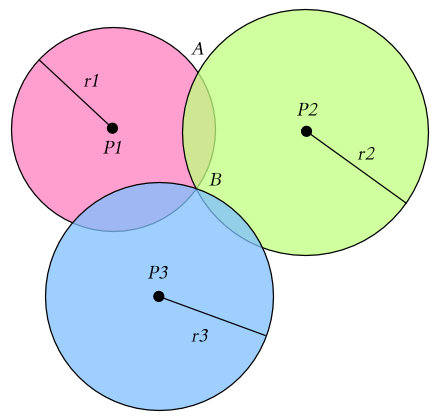
*Image from [Wikipedia: Lateration](https://de.wikipedia.org/wiki/Lateration)*
4. Repeat previous steps for all known beacons in selected buildings

### 1. Assign each iBeacon distance to a waypoint position in building.
For a sample path, we get the following **iBeacon and waypoint data**.

In [ ]:
sample_building = '5a0546857ecc773753327266'
sample_floor = 'B1'
sample_path = f'{PATH}train/{sample_building}/{sample_floor}/5e15731fa280850006f3d013.txt'
print(f"Sample path: {sample_path}")

path = read_data_file(sample_path)

ibeacon_df = to_frame(path.ibeacon,'ibeacon')
display(ibeacon_df.head().style.set_caption('DataFrame Head of iBecon Data'))
display(ibeacon_df.id.value_counts())

waypoint_df = to_frame(path.waypoint,'waypoint')
display(waypoint_df.head().style.set_caption('DataFrame Head of Waypoint Data'))

We can see that the waypoint data and the iBeacon data have different timestamps. Therefore, we cannot map a position to the iBeacon data directly.
Instead, we will create a **lookup table to distinguish the position for each timestamp. Note that this method is NOT precise** but sufficient for the intended purpose.  

The lookup table is created by combining the iBeacon DataFrame with the waypoint DataFrame. Then the new combined dataframe is sorted by timestamps. Finally, the **waypoint data for the iBeacon timestamps is imputed by interpolation**.

In [ ]:
# Get iBeacon timestamps
ibeacon_df_grouped = ibeacon_df.groupby('timestamp')['id'].unique().to_frame().reset_index(drop=False)
display(ibeacon_df_grouped.head().style.set_caption("iBeacon Timestamps"))

# Combine with waypoint data
waypoint_ble_combined = pd.concat([ibeacon_df_grouped, waypoint_df])
waypoint_ble_combined = waypoint_ble_combined.sort_values(by='timestamp').reset_index(drop=True)

display(waypoint_ble_combined.head().style.set_caption('Combined Dataframe of Waypoint and iBeacon Timestamps Sorted by Time'))

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14, 6))
sns.lineplot(x=waypoint_ble_combined.timestamp, y=waypoint_ble_combined.x, marker='o', ax=ax[0], label = 'before interpolation', color='orange')
sns.lineplot(x=waypoint_ble_combined.timestamp, y=waypoint_ble_combined.y, marker='o', ax=ax[1], label = 'before interpolation', color='orange')

# Interpolate waypoint
waypoint_ble_combined.x = waypoint_ble_combined.x.interpolate()
waypoint_ble_combined.y = waypoint_ble_combined.y.interpolate()

sns.lineplot(x=waypoint_ble_combined.timestamp, y=waypoint_ble_combined.x, marker='o', ax=ax[0], label = 'after interpolation', color='blue')
sns.lineplot(x=waypoint_ble_combined.timestamp, y=waypoint_ble_combined.y, marker='o', ax=ax[1], label = 'afte interpolationr', color='blue')

plt.show()

display(waypoint_ble_combined.head().style.set_caption("Lookup Table with Interpolated Waypoint Data for iBeacon Timestamps"))

Next we will map the waypoint data from the lookup table to the iBeacon dataframe to the corresponding timestamp.

In [ ]:
ble_df_with_waypoint = ibeacon_df.merge(waypoint_ble_combined[['timestamp', 'x', 'y']], on='timestamp', how='left')
display(ble_df_with_waypoint.head().style.set_caption("iBeacon Dataframe with added waypoint data"))

### 2. Gather all iBeacon distance / position pairs for each beacon.
Let's repeat above step for all training files in the given building on the given floor.

In [ ]:
ble_list = pd.DataFrame()
df = train_df[train_df.building == sample_building]

files = df[df.floor == sample_floor].path.unique()

for file in (files):

    path = read_data_file(f"{PATH}train/{sample_building}/{sample_floor}/{file}")
    
    # Get path's wifi and waypoint data
    ibeacon_df = to_frame(path.ibeacon,'ibeacon')
    waypoint_df = to_frame(path.waypoint,'waypoint')

    # Combine wifi and waypoint dataframe to one dataframe
    ibeacon_df_grouped = ibeacon_df.groupby('timestamp')['id'].nunique().to_frame().reset_index(drop=False)
    waypoint_ble_combined = pd.concat([ibeacon_df_grouped, waypoint_df])
    waypoint_ble_combined = waypoint_ble_combined.sort_values(by='timestamp').reset_index(drop=True)

    # Interpolate waypoint data for wifi timestamps
    waypoint_ble_combined.x = waypoint_ble_combined.x.interpolate()
    waypoint_ble_combined.y = waypoint_ble_combined.y.interpolate()

    # Map wifi timestamps to wifi dataframe
    ble_df_with_waypoint = ibeacon_df.merge(waypoint_ble_combined[['timestamp', 'x', 'y']], on='timestamp', how='left')


    # Append to dataframe holding all wifi data for this floor
    ble_list = ble_list.append(ble_df_with_waypoint)

display(ble_list.head().style.set_caption(f"All iBeacon data for floor {sample_floor} in building {sample_building}"))


Below you can see the frequency of each beacon. One beacon has over 26,000 datapoints, while there are two beacons with only 1 datapoint.

In [ ]:
display(ble_list.id.value_counts().to_frame().head(10))

### 3. Use lateration to determine the beacons position in the building

Before we begin, let's plot a few BLE signals to get a feeling for the data.

In [ ]:
def plot_ibeacon_signal(path, building, floor, identifier):
    """
    Copied and edited from https://www.kaggle.com/robikscube/indoor-navigation-snap-to-grid-post-processing
     
    For every available position the distance to a selected beacon is plotted as a circle.
    The circles center is the corresponding x,y position.
    The circles radius is the corresponding distance.
    The x, y, and distance as scaled to match the maps dimensions for the visualization.
    
    Arg in:
    * path: data directory for the floor images and floor info
    * building: target building to be plotted
    * floor: target floor in target building to be plotted
    * identifier: selected beacon's ID to which the distances shall be plotted
    
    Output:
    A visualization of the target building's target floor with circles representing the distances.
    """

    # Prepare width_meter & height_meter (taken from the .json file)
    floor_plan_filename = f"{path}/metadata/{building}/{floor}/floor_image.png"
    json_plan_filename = f"{path}/metadata/{building}/{floor}/floor_info.json"

    # Load and extract floor dimensions in meter
    with open(json_plan_filename) as json_file:
        json_data = json.load(json_file)

    width_meter = json_data["map_info"]["width"]
    height_meter = json_data["map_info"]["height"]

    # Load floor map as image
    floor_img = plt.imread(f"{path}/metadata/{sample_building}/{sample_floor}/floor_image.png")

    # Get datapoints for single beacon
    ble_df = ble_list[ble_list.id ==identifier]

    # Scale x, y, and distance to match floor with sclaer = floor_img.shape[0] / height_meter = floor_img.shape[1] / width_meter)
    ble_df["x_scaled"] = ble_df["x"] * floor_img.shape[0] / height_meter
    ble_df["y_scaled"] = (ble_df["y"] * -1 * floor_img.shape[1] / width_meter) + floor_img.shape[0]
    ble_df["distance_scaled"] = ble_df["distance"].astype(float) * floor_img.shape[0] / height_meter

    # Plot distance to beacon from x,y position as circle 
    fig, ax = plt.subplots(figsize=(12, 12))
    plt.imshow(floor_img)
    for i in range(len(ble_df)):
        circle=plt.Circle((ble_df["x_scaled"].values[i], ble_df["y_scaled"].values[i]), ble_df["distance_scaled"].values[i], color='dodgerblue', fill=False)
        ax.add_patch(circle)
    ax.set_title(f"Building {building}, Floor {floor} \n Beacon ID {identifier}")
    plt.show()


In the below example, there were 2340 datapoints available. However, we might wonder how it is even possible to have a BLE signal when at the top left corner and at the same time at middle.

In [ ]:
plot_ibeacon_signal(PATH, sample_building, sample_floor, "89cb11b04122cef23388b0da06bd426c1f48a9b5_cfc84f0752adc96b489f71195d91a946c5f6d3e8_8159618423dfa22f1ca0b62543e2f18eef630ce8")

One reason might be that the weaker the signal the less confident we can be in the signals accuracy. Therefore, let's look at the signals in close approximity only (< 3m). However, we can see that even with this stricter selection of iBeacon data, it still looks like there are **three (and a half) possible positions of the beacon**.

At this stage, it either looks like the identifier is not uniquely identifying a single beacon or the beacons are changing positions or the BLE RSSI is not realible.

In [ ]:
path = PATH
building = sample_building
floor = sample_floor
identifier = "89cb11b04122cef23388b0da06bd426c1f48a9b5_cfc84f0752adc96b489f71195d91a946c5f6d3e8_8159618423dfa22f1ca0b62543e2f18eef630ce8"


# Prepare width_meter & height_meter (taken from the .json file)
floor_plan_filename = f"{path}/metadata/{building}/{floor}/floor_image.png"
json_plan_filename = f"{path}/metadata/{building}/{floor}/floor_info.json"

with open(json_plan_filename) as json_file:
    json_data = json.load(json_file)

width_meter = json_data["map_info"]["width"]
height_meter = json_data["map_info"]["height"]

floor_img = plt.imread(f"{PATH}/metadata/{sample_building}/{sample_floor}/floor_image.png")

ble_df = ble_list[ble_list.id ==identifier]
ble_df.distance = ble_df.distance.astype(float)
ble_df["x_"] = ble_df["x"] * floor_img.shape[0] / height_meter
ble_df["y_"] = (ble_df["y"] * -1 * floor_img.shape[1] / width_meter) + floor_img.shape[0]
ble_df["distance_"] = ble_df["distance"].astype(float) * floor_img.shape[0] / height_meter

ble_df = ble_df[ble_df.distance < 3]
display(ble_df.head().style.set_caption("iBeacon datapoints in close approximity (< 3m)"))
fig, ax = plt.subplots(figsize=(12, 12))
plt.imshow(floor_img)
for i in range(len(ble_df)):
    circle=plt.Circle((ble_df["x_"].values[i], ble_df["y_"].values[i]), ble_df["distance_"].values[i], color='dodgerblue', fill=False)
    ax.add_patch(circle)
    
circle=plt.Circle((480, 320), 60, color='red', fill=False)
ax.add_patch(circle)

circle=plt.Circle((140, 70), 50, color='red', fill=False)
ax.add_patch(circle)

circle=plt.Circle((340, 120), 75, color='red', fill=False)
ax.add_patch(circle)

ax.set_title(f"Building {building}, Floor {floor} \n Beacon ID {identifier}")
plt.show()


For sanity reasons, let's check another beacon. For the below beacon, it looks like we could apply some form of lateration. If you search for where most of the circles are intersecting, you could guess that the beacons position could be roughly located at the position of the red dot. This one gives us a little bit of hope that our idea is feasible.

In [ ]:
#plot_ibeacon_signal(PATH, sample_building, sample_floor, "4e9d3569a79dcbd102831d1bd587aa4e868ae797_2be4ebd5d986f25c1c84ff3d1536595914dab649_6b742085bcd69795bc6f371a635f62f3b2e3e2c5")
path = PATH
building = sample_building
floor = sample_floor
identifier = "4e9d3569a79dcbd102831d1bd587aa4e868ae797_2be4ebd5d986f25c1c84ff3d1536595914dab649_6b742085bcd69795bc6f371a635f62f3b2e3e2c5"


# Prepare width_meter & height_meter (taken from the .json file)
floor_plan_filename = f"{path}/metadata/{building}/{floor}/floor_image.png"
json_plan_filename = f"{path}/metadata/{building}/{floor}/floor_info.json"

with open(json_plan_filename) as json_file:
    json_data = json.load(json_file)

width_meter = json_data["map_info"]["width"]
height_meter = json_data["map_info"]["height"]

floor_img = plt.imread(f"{PATH}/metadata/{sample_building}/{sample_floor}/floor_image.png")

ble_df = ble_list[ble_list.id ==identifier]

ble_df["x_"] = ble_df["x"] * floor_img.shape[0] / height_meter
ble_df["y_"] = (ble_df["y"] * -1 * floor_img.shape[1] / width_meter) + floor_img.shape[0]
ble_df["distance_"] = ble_df["distance"].astype(float) * floor_img.shape[0] / height_meter

fig, ax = plt.subplots(figsize=(12, 12))
plt.imshow(floor_img)
for i in range(len(ble_df)):
    circle=plt.Circle((ble_df["x_"].values[i], ble_df["y_"].values[i]), ble_df["distance_"].values[i], color='dodgerblue', fill=False)
    ax.add_patch(circle)
    
circle=plt.Circle((335, 195), 5, color='red')
ax.add_patch(circle)


ax.set_title(f"Building {building}, Floor {floor} \n Beacon ID {identifier}")
plt.show()


Let's look at one more beacon. This time we only have 12 datapoints. In theory, this should be enough for trilateration. However, if you look at the below figure, it is difficult to visually estimate the position of the beacon.

In [ ]:
plot_ibeacon_signal(PATH, sample_building, sample_floor, "7545e168924d7dd838162d5ba572786e2c47c7ff_b6589fc6ab0dc82cf12099d1c2d40ab994e8410c_ef92237676503daee4b9f2c7f3ffce1a980fc403")

At this stage, **it does not seem to be feasible to determine the position of the beacons in the training data as an additional feature**. 

# Floor Level Accuracy
Let's see if the iBeacon data can at least support determining the floor in a building. For this purpose, we will follow the simple recipe demonstrated in the notebook [Simple 👌 99% Accurate Floor Model 💯](https://www.kaggle.com/nigelhenry/simple-99-accurate-floor-model). The notebook by [@nigelhenry](https://www.kaggle.com/nigelhenry) follows the following steps for the WiFi signal to determine floor.
> 1. Construct a floor-bssid-max(RSSI) frequency table for each site
2. Give each floor 1 point for every bssid-RSSI pair that falls within the max(RSSI) previously observed on that floor
3. Take the highest-voted floor.
Let's evaluate if the same steps can be applied to the iBeacon data.



Below, I have gathered all iBeacon signals on each floor for the sample building.

In [ ]:
ble_list = pd.DataFrame()
df = train_df[train_df.building == sample_building]

for floor in tqdm(df.floor.unique()):
    files = df[df.floor == floor].path.unique()

    for file in (files):

        path = read_data_file(f"{PATH}train/{sample_building}/{floor}/{file}")

        # Get path's wifi and waypoint data
        ibeacon_df = to_frame(path.ibeacon,'ibeacon')
        waypoint_df = to_frame(path.waypoint,'waypoint')

        # Combine wifi and waypoint dataframe to one dataframe
        ibeacon_df_grouped = ibeacon_df.groupby('timestamp')['id'].nunique().to_frame().reset_index(drop=False)
        waypoint_ble_combined = pd.concat([ibeacon_df_grouped, waypoint_df])
        waypoint_ble_combined = waypoint_ble_combined.sort_values(by='timestamp').reset_index(drop=True)

        # Interpolate waypoint data for wifi timestamps
        waypoint_ble_combined.x = waypoint_ble_combined.x.interpolate()
        waypoint_ble_combined.y = waypoint_ble_combined.y.interpolate()

        # Map wifi timestamps to wifi dataframe
        ble_df_with_waypoint = ibeacon_df.merge(waypoint_ble_combined[['timestamp', 'x', 'y']], on='timestamp', how='left')

        ble_df_with_waypoint['floor'] = floor
        # Append to dataframe holding all wifi data for this floor
        ble_list = ble_list.append(ble_df_with_waypoint)

ble_list.distance = ble_list.distance.astype(float)
display(ble_list.head().style.set_caption(f"All iBeacon data for building {sample_building}"))

Below you can see on how many floors an identifier's signal is received. Although ideally, we would want an identifier's signal to be received only on one floor, we can expected a beacons signal to be received in th floor above or below as well. This means, that we would expected a maximum of three floors for a beacon's signal to be received. However, below we can see two beacons whose signals are received on five floors. This seems suspicious.

In [ ]:
ble_list.groupby('id').floor.nunique().to_frame().sort_values(by='floor', ascending=False).reset_index(drop=False).head(10)

Let's see what happens if we only use strong signals from beacons in close approximity (< 3m). We still have the two entries with strong signals on all five floors. This seems implausible. However, we now have fewer beacons whose signals are received on multiple floors.

In [ ]:
ble_list[ble_list.distance < 3].groupby('id').floor.nunique().to_frame().sort_values(by='floor', ascending=False).reset_index(drop=False).head(10)

However, if we visualize the beacons' signals, we can at least roughly evaluate on which level the beacon must be located. Note, that the below shown lookup table does not include all beacons in the building.

In [ ]:
beacon_floor_mapping = ble_list[ble_list.distance < 3].groupby(['id', 'floor']).floor.count().to_frame()
beacon_floor_mapping.columns = ['num_signals']
beacon_floor_mapping = beacon_floor_mapping.reset_index(drop=False)
beacon_floor_mapping = beacon_floor_mapping.pivot(index = 'id', columns='floor').num_signals.fillna(0)
beacon_floor_mapping['located_on'] = beacon_floor_mapping.idxmax(axis=1)
beacon_floor_mapping.reset_index(drop=False, inplace=True)
beacon_floor_mapping.style.set_properties(subset=['id'], **{'width': '300px'}).background_gradient(subset=["B1", "F1", "F2", "F3", "F4"], cmap='Blues', vmin=0, vmax=1500).format({"B1": "{:.0f}", "F1": "{:.0f}", "F2": "{:.0f}", "F3": "{:.0f}", "F4": "{:.0f}", "F5": "{:.0f}", }).set_caption('Number Strong iBeacon Signals in Sample Building')

Let's see if the above lookup table can be used as an additional feature. We will merge the `located_on` feature to the dataframe of your sample path.

In [ ]:
path = read_data_file(sample_path)

# Get path's wifi and waypoint data
ibeacon_df = to_frame(path.ibeacon,'ibeacon')
waypoint_df = to_frame(path.waypoint,'waypoint')

# Combine wifi and waypoint dataframe to one dataframe
ibeacon_df_grouped = ibeacon_df.groupby('timestamp')['id'].nunique().to_frame().reset_index(drop=False)
waypoint_ble_combined = pd.concat([ibeacon_df_grouped, waypoint_df])
waypoint_ble_combined = waypoint_ble_combined.sort_values(by='timestamp').reset_index(drop=True)

# Interpolate waypoint data for wifi timestamps
waypoint_ble_combined.x = waypoint_ble_combined.x.interpolate()
waypoint_ble_combined.y = waypoint_ble_combined.y.interpolate()

# Map wifi timestamps to wifi dataframe
ble_df_with_waypoint = ibeacon_df.merge(waypoint_ble_combined[['timestamp', 'x', 'y']], on='timestamp', how='left')

# Merge with lookup table
X = ble_df_with_waypoint.merge(beacon_floor_mapping[['id', 'located_on']], on='id', how='left')
X.distance = X.distance.astype(float)
display(X.head())

Now, if we use the `value_counts()` function, we can see that this path could either be located on B1 or F4. However, if we only look at the iBeacon signals in clsoe approximity (<3m), we can say with high confidence that the sample path is located on B1, which is in fact correct. One pitfall to note here, is that the lookup table contains information from the sample path as well. If you would want to evaluate the accuracy of this method, it would be better to create a lookup table excluding the validation data.

Since the aim of this notebook is only to evaluate the feasibility of iBeacon data usage, I will not determine the accuracy of this method. However, I think it is save to say that the **iBeacon data could be used to support floor level classification. However, I would not recommend to use it on its own but instead combine it at least with WiFi**.

In [ ]:
display(X.located_on.value_counts())
display(X[X.distance < 3].located_on.value_counts())

# Summary
* iBeacon technology is only be capable of providing room-level accuracy [2]
* Kagglers have reported that adding iBeacon data seems to worsen the precision (see [discussion topic "How much value is TYPE_BEACON adding?"](https://www.kaggle.com/c/indoor-location-navigation/discussion/222488))
* Analysis showed that it does not seem to be feasible to determine the position of the beacons in the training data as an additional feature.
* iBeacon data could be used to support floor level classification. However, it is not recommended to use it on its own but instead combine it at least with WiFi data.

# References
[1] https://en.wikipedia.org/wiki/IBeacon

[2] https://developer.apple.com/ibeacon/Getting-Started-with-iBeacon.pdf

[3] https://github.com/location-competition/indoor-location-competition-20

[4] https://de.wikipedia.org/wiki/Lateration

# Code References
https://github.com/location-competition/indoor-location-competition-20

https://www.kaggle.com/jiweiliu/wifi-label-encode

https://www.kaggle.com/devinanzelmo/wifi-features

https://www.kaggle.com/robikscube/indoor-navigation-snap-to-grid-post-processing

https://www.kaggle.com/nigelhenry/simple-99-accurate-floor-model